## Load Data

First, we use 'pickled' files to load the traffic sign data!

Then, we categorize the training and testing set's features (basis on which we classify images)
and labels (basis on which we categorise the images)

In [1]:
import pickle

# TODO: Fill this in based on where you saved the training and testing data

# Say we have a dictionary of images and a list of labels - we can append the labels to the corresponding images
# by using pickled format in python. In other words, we can say it's used for Serialization 
# (process of translating data structures or object state into a format that can be stored)
# In other words, the 'pickled' format can be stored and our images and labels 

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

In [2]:
import numpy as np

# In this block of code, we simply use the python function `len()` to get the length of various subsets of data
# This is an essential step of data science and we do it to better understand the data we have.


# Number of training samples.
n_train = len(x_train)

# Number of testing samples.
n_test = len(x_test)

# The variable `shape` is defined on the dataset. This returns the dimensions of the first image:
image_shape = x_train[0].shape

# We use the `unique()` function of numpy with `y_train` parameters and nest it in the len() function
# in order to find out the length of unique labels in our training set.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Visualize Data

View a sample from the dataset.

This is also an extremely important part of data science. We plot graphically and view random samples of the 
initial data we have, so we can better understand what is required to clean/augment it.


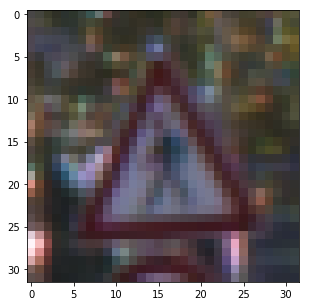

Class : 27


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

# We use the following block of code to generate a random index, ranging upto the set of training data
# Then, we plot the image to have a better understanding of the type of data we are working with.

index = random.randint(0, len(x_train))
image = x_train[index]

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.show()

print("Class :", y_train[index])

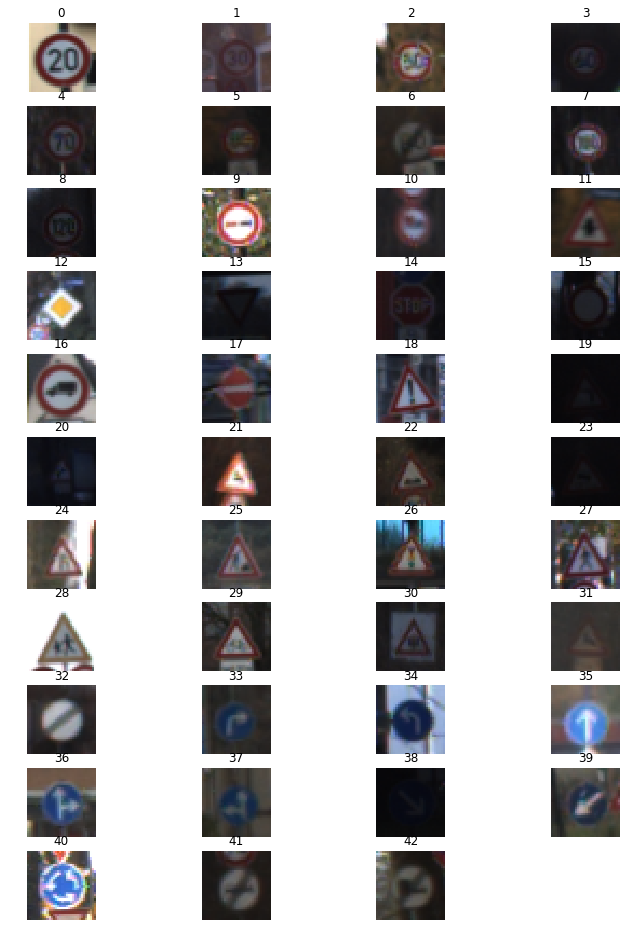

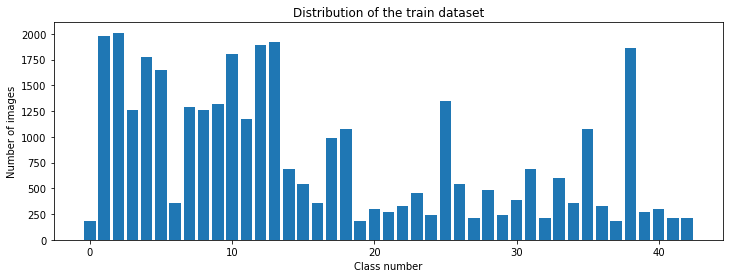

Min number of images in any one given class = 180
Max number of images in any one given class = 2010


In [4]:
# Initialise a list and plot the various different types of images we have (images of each class)
# Note: We have 43 classes of signs.

num_of_samples=[]
plt.figure(figsize=(12, 16.5))
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    x_selected = x_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) # Draw the first image of each class
    plt.title(i)
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()

# Plot number of images per class
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

print("Min number of images in any one given class =", min(num_of_samples))
print("Max number of images in any one given class =", max(num_of_samples))

In [5]:
# The `sklearn` package contains a method which allows us to divide our training and validation data in a specific ratio
# Here, we chose to divide our data in a 80:20 ratio of training:validation data.

from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.2,random_state=0)
print(x_train[0].shape)

(32, 32, 3)


## Preprocess Data

Shuffle the training data.


In [6]:
# We shuffle the training data by using the algorithm below. This is necessary to ensure that our prediction results
# On our validation data aren't just being generated because our data is arranged in a specific way.

# Further, we reduce our images which are currently in the RGB color model to grayscale, but retain the shape 
# ie. (x-y-z axis). This is done as the LeNet architecture which we will use on our data accepts data of the 32x32xC
# format. Hence, we must retain the z-axis.

x_train_gry=np.sum(x_train/3, axis=3, keepdims=True)
x_test_gry=np.sum(x_test/3, axis=3, keepdims=True)
x_valid_gry=np.sum(x_valid/3, axis=3, keepdims=True)

X_train=x_train_gry
X_test=x_test_gry
X_valid=x_valid_gry

In [7]:
# While training the model, the dataset should be as uniform as possible. The intensity of images lie 
# between 0 and 256, thus we convert it to the range of -1 and 1 to bring uniformity in the dataset.

X_train=(X_train-128)/128
X_test=(X_test-128)/128
X_valid=(X_valid-128)/128

In [8]:
# Checking the shape of the training image

X_train[0].shape

(32, 32, 1)

In [9]:
import cv2

# Here, we created 4 functions through which we can perform various transformations on the traffic signs.
# random_translate() is used to shift along the x and y axis.
# random_scaling() is used to magnify/scale the traffic signs.
# random_warp() is used to apply an affine transformation to the traffic signs.
# random_brightness() is used to self explanatory.

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

# Data Augmentation


In [10]:
# We have set the samples_threshold_value to 800 which signifies the minimum number of samples of a class
# required to train the model. In some cases, we do not have 800 samples in our dataset
# (as visualised by the graph containing each class of images).
# Thus, we increase data samples to this threshold value by generating new images
# using augmentation functions like translate, scaling, warp and brightness.

samples_threshold_value = 800

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < samples_threshold_value:
        for i in range(samples_threshold_value - n_samples):
            img = X_train[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(img))))
            X_train = np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
    
print('X, y shapes:', X_train.shape, y_train.shape)

0 : |----|----|----|----|----|----|----|----|----|----|----|----|----|
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|----|----|----
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |----|----|----|----|----|
15 : |----|----|----|----|----|----|----|-
16 : |----|----|----|----|----|----|----|----|----|----|-
17 : |
18 : 
19 : |----|----|----|----|----|----|----|----|----|----|----|----|----|
20 : |----|----|----|----|----|----|----|----|----|----|----|-
21 : |----|----|----|----|----|----|----|----|----|----|----|---
22 : |----|----|----|----|----|----|----|----|----|----|---
23 : |----|----|----|----|----|----|----|----|----
24 : |----|----|----|----|----|----|----|----|----|----|----|----|
25 : 
26 : |----|----|----|----|----|----|----|-
27 : |----|----|----|----|----|----|----|----|----|----|----|----|---
28 : |----|----|----|----|----|----|----|----|-
29 : |----|----|----|----|----|----|----|----|----|----|----|----|
30 : |----|----|----|----|----|----|----|----|----|-

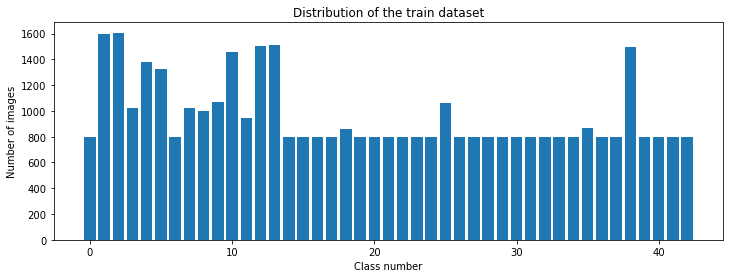

Min number of images in any one given class = 800
Max number of images in any one given class = 1607


In [11]:
# After augmenting the data, we plot the distribution of the training dataset

num_of_samples=[]
for i in range(0, n_classes):
    x_selected = X_train[y_train == i]
    num_of_samples.append(len(x_selected))

# Plot number of images per class
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

print("Min number of images in any one given class =", min(num_of_samples))
print("Max number of images in any one given class =", max(num_of_samples))

In [12]:
# utils module of sklearn library contain a function named shuffle which can be used to mix the dataset properly.

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [13]:
# Save the augmented data in a new file

new_training_data_file = 'train.p'

with open(new_training_data_file, mode='wb') as f:
    pickle.dump({'features' : X_train, 'labels' : y_train}, f)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [1]:
# Read the data from the file
import pickle 

with open('train.p', mode='rb') as f:
    train = pickle.load(f)

X_train, Y_train = train['features'], train['labels']

In [2]:
from sklearn.model_selection import train_test_split

x_train, x_remaining, y_train, y_remaining = train_test_split(X_train, Y_train, test_size=0.4,random_state=0)
x_valid, x_test, y_valid, y_test = train_test_split(x_remaining, y_remaining, test_size=0.5, random_state=0)

print(x_train[0].shape)

(32, 32, 1)


In [3]:
import cv2
import tensorflow as tf

EPOCHS = 25
BATCH_SIZE = 120

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.

### Architecture
**Layer 1: Convolutional.** 5x5x1x6 filter ,outputs 28X28X6.

**Activation.** Relu Activation.

**Pooling.** 2X2 filter with stride 2,outputs 14x14x6.

**Layer 2: Convolutional.** 5X5x6x16 filter,outputs 10x10x16

**Activation.** Relu Activation.

**Pooling.** 2X2 filter with stride 2,outputs 5x5x16.

**Layer 3: Convolutional.** 5X5x16x400 filter,outputs 1x1x400

**Activation.** Relu Activation.

**Flatten.** Concatenation of layer 2 and layer 3 after flattening,outputs 1x800

**Dropout.** Dropout with prob 0.5 on training data.

**Layer 5: Fully Connected (Logits).** Gives 43 outputs.

### Output

In [4]:
from tensorflow.contrib.layers import flatten

In [5]:
def traffic_sign(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights={
        'wc1':tf.Variable(tf.truncated_normal(shape=(5,5,1,6),mean = mu, stddev = sigma)),
        'wc2':tf.Variable(tf.truncated_normal(shape=(5,5,6,16),mean = mu, stddev = sigma)),
        'wc3':tf.Variable(tf.truncated_normal(shape=(5,5,16,400),mean = mu, stddev = sigma)),
        'out':tf.Variable(tf.truncated_normal(shape=(800,43),mean = mu, stddev = sigma))
    }
    biases={
        'bc1':tf.Variable(tf.zeros((6,))),
        'bc2':tf.Variable(tf.zeros((16,))),
        'bc3':tf.Variable(tf.zeros((400,))),
        'out':tf.Variable(tf.zeros((43,)))
    }
    
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    layer1=tf.nn.conv2d(x,weights['wc1'],strides=[1,1,1,1],padding='VALID')+biases['bc1']
    # TODO: Activation.
    layer1=tf.nn.relu(layer1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    layer1=tf.nn.max_pool(layer1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    print(layer1.get_shape())
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    layer2=tf.nn.conv2d(layer1,weights['wc2'],strides=[1,1,1,1],padding='VALID')+biases['bc2']
    # TODO: Activation.
    layer2=tf.nn.relu(layer2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    layer2=tf.nn.max_pool(layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    print(layer2.get_shape())
    
    # TODO: Layer 3: Convolutional. Output = 1x1x400.
    layer3=tf.nn.conv2d(layer2,weights['wc3'],strides=[1,1,1,1],padding='VALID')+biases['bc3']
    # TODO: Activation.
    layer3=tf.nn.relu(layer3)
    print(layer3.get_shape())
    
    layer2_flat=flatten(layer2)
    layer3_flat=flatten(layer3)
    
    layer4=tf.concat_v2([layer3_flat, layer2_flat], 1)
    # Dropout
    layer4=tf.nn.dropout(layer4,keep_prob)
    
    logits=tf.add(tf.matmul(layer4,weights['out']),biases['out'])
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [6]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob=tf.placeholder(tf.float32)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [7]:
rate = 0.0009
KEEP_PROB = 0.5
logits = traffic_sign(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 14, 14, 6)
(?, 5, 5, 16)
(?, 1, 1, 400)


## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [9]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, Y_train = shuffle(X_train, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        validation_accuracy = evaluate(x_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.864

EPOCH 2 ...
Validation Accuracy = 0.935

EPOCH 3 ...
Validation Accuracy = 0.960

EPOCH 4 ...
Validation Accuracy = 0.977

EPOCH 5 ...
Validation Accuracy = 0.984

EPOCH 6 ...
Validation Accuracy = 0.986

EPOCH 7 ...
Validation Accuracy = 0.992

EPOCH 8 ...
Validation Accuracy = 0.993

EPOCH 9 ...
Validation Accuracy = 0.994

EPOCH 10 ...
Validation Accuracy = 0.995

EPOCH 11 ...
Validation Accuracy = 0.996

EPOCH 12 ...
Validation Accuracy = 0.997

EPOCH 13 ...
Validation Accuracy = 0.998

EPOCH 14 ...
Validation Accuracy = 0.997

EPOCH 15 ...
Validation Accuracy = 0.998

EPOCH 16 ...
Validation Accuracy = 0.998

EPOCH 17 ...
Validation Accuracy = 0.998

EPOCH 18 ...
Validation Accuracy = 0.999

EPOCH 19 ...
Validation Accuracy = 0.999

EPOCH 20 ...
Validation Accuracy = 0.999

EPOCH 21 ...
Validation Accuracy = 1.000

EPOCH 22 ...
Validation Accuracy = 0.999

EPOCH 23 ...
Validation Accuracy = 1.000

EPOCH 24 ...
Validation Accura

## Evaluate the Model
Once we are completely satisfied with our model, we evaluate the performance of the model on the test set.


If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [10]:
with tf.Session() as sess:
   saver.restore(sess, tf.train.latest_checkpoint('.'))
   test_accuracy = evaluate(x_test, y_test)
   print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 1.000


# Normalizing and preprocessing new images

In [22]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,6, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

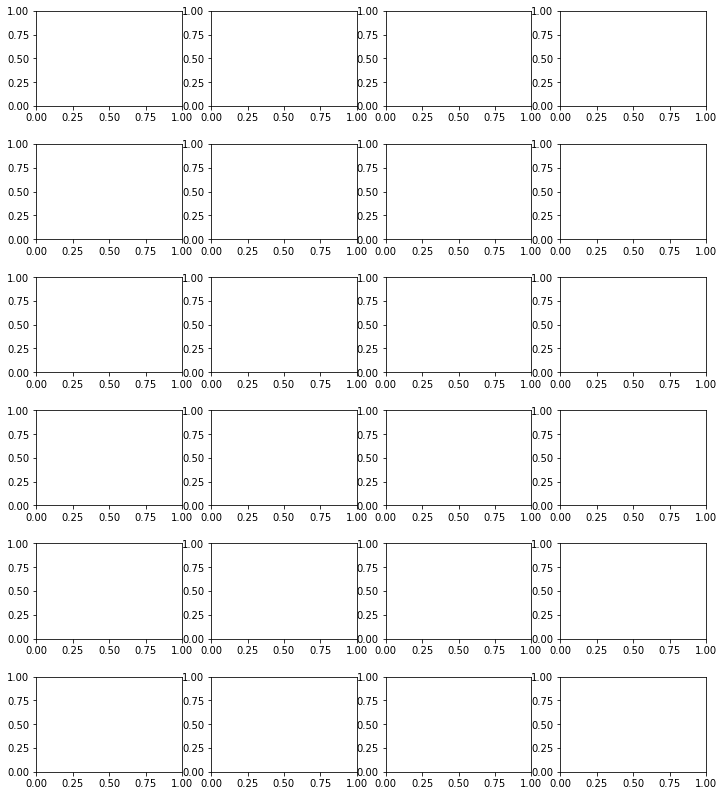

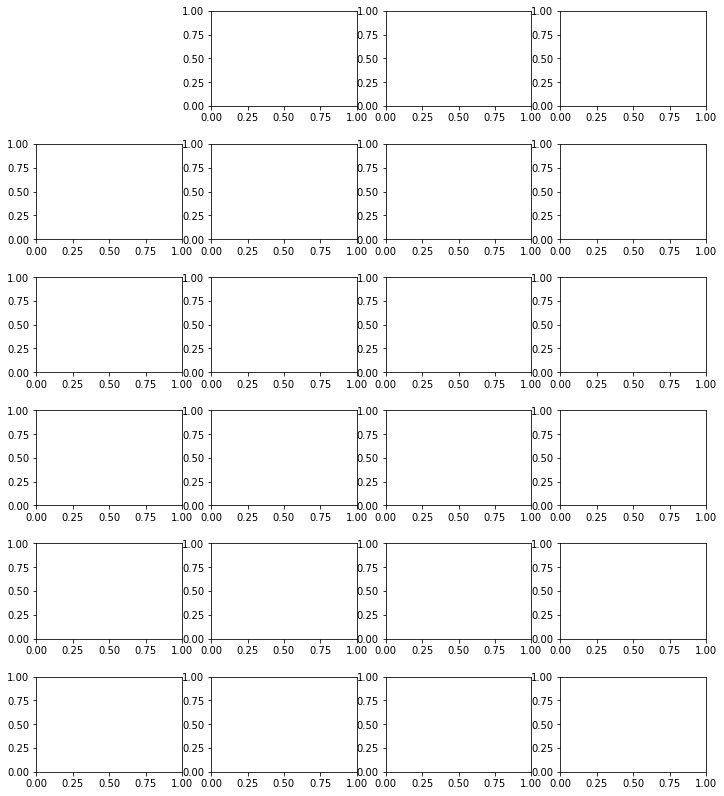

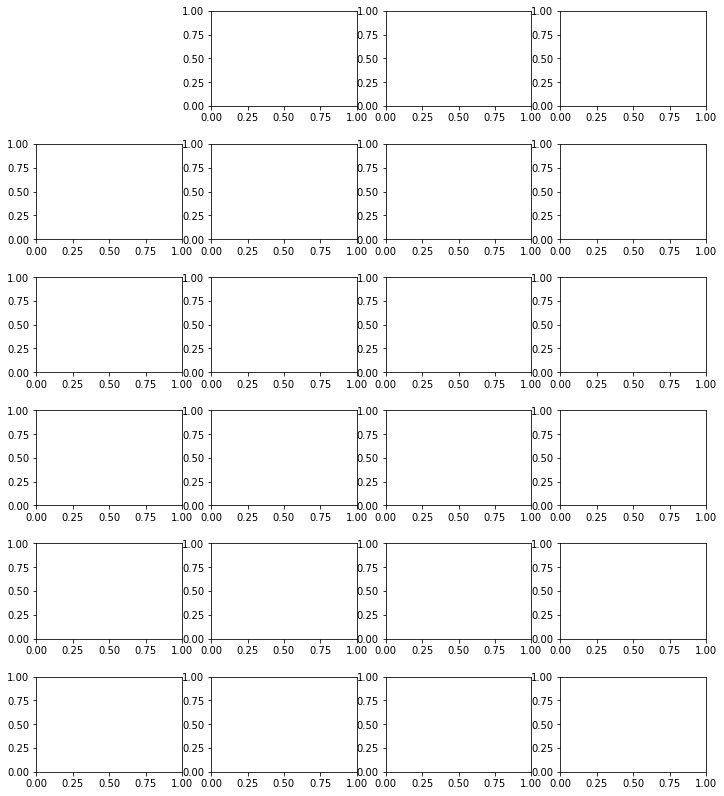

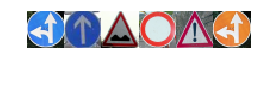

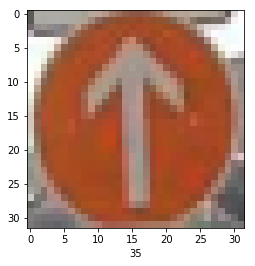

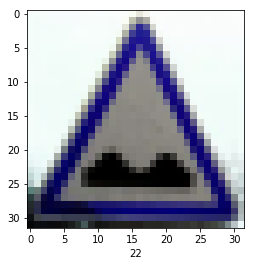

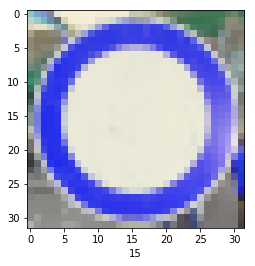

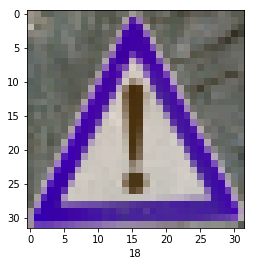

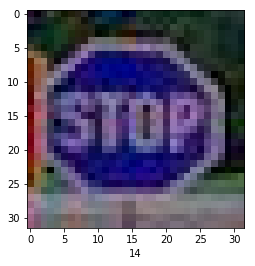

In [23]:
import numpy as np

new_images=[]
new_labels=[37,35,22,15,18,14]

for i, img in enumerate(glob.glob('./new_images/*.jpg')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    new_images.append(image)

new_images=np.asarray(new_images)
new_labels=np.asarray(new_labels)

for i in range(len(new_images)):
    plt.imshow(new_images[i])
    plt.xlabel(new_labels[i])
    plt.show()
    
# Clear the plot
plt.clf()

In [24]:
my_images = new_images
new_images=np.sum(new_images/3, axis=3, keepdims=True)
new_images=(new_images-128)/128

In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(new_images, new_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 1.000


In [26]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    single_image_accuracy = evaluate(new_images[:1], new_labels[:1])
print(single_image_accuracy)

1.0


# Softmax Probabilities 

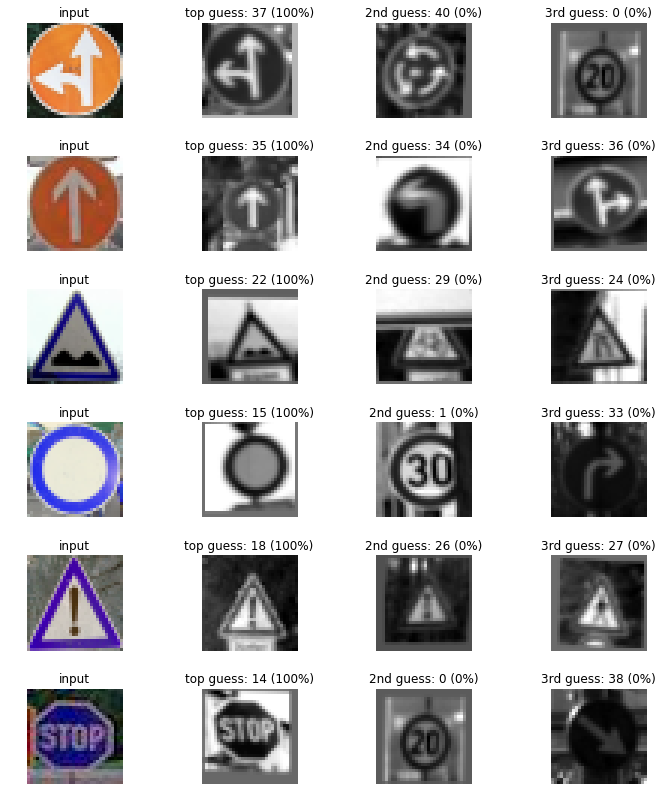

In [27]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: new_images, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: new_images, keep_prob: 1.0})

    
    fig, axs = plt.subplots(len(new_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(image)
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(x_valid[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(x_valid[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(x_valid[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))
        
    plt.show()

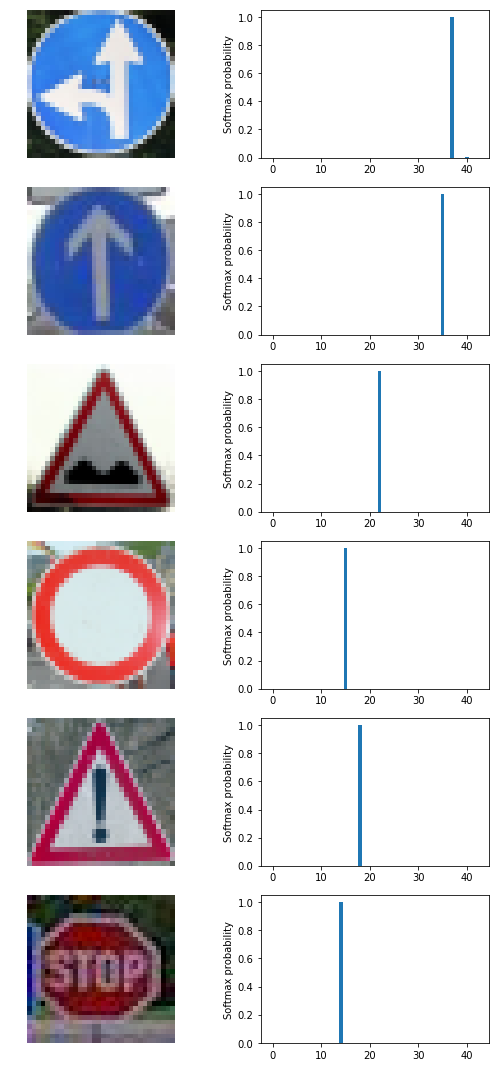

In [28]:
fig, axs = plt.subplots(6,2, figsize=(9, 19))
axs = axs.ravel()

n_classes = 43

for i in range(len(my_softmax_logits)*2):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(cv2.cvtColor(my_images[i//2], cv2.COLOR_BGR2RGB))
    else:
        axs[i].bar(np.arange(n_classes), my_softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Softmax probability')
        
plt.show()

## Runtime Classification

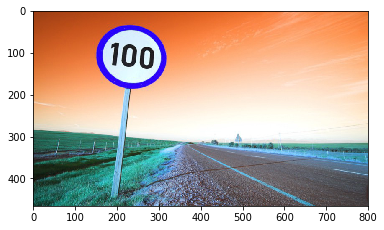

(466, 800, 3)


In [29]:
plt.clf()

image = cv2.imread('./video_images/sign1.jpeg')
image = np.asarray(image)

plt.imshow(image)
plt.show()

print(image.shape)

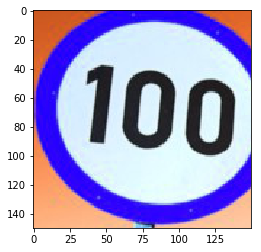

In [30]:
# Crop the image according to the sign position
image = image[40:190, 150:300]
plt.imshow(image)
plt.show()

In [31]:
'''
# Shape of the image
img_shape = image.shape

img_height = img_shape[0]
img_width = img_shape[1]

print(img_height, img_width)
'''

'\n# Shape of the image\nimg_shape = image.shape\n\nimg_height = img_shape[0]\nimg_width = img_shape[1]\n\nprint(img_height, img_width)\n'

In [32]:
'''
# Calculate number of bounding boxes

step_size = 10

box_width = 50
box_height = 50

x_steps = ((img_width - box_width)//step_size) + 1
y_steps = ((img_height - box_height)//step_size) + 1

print(x_steps, y_steps, x_steps*y_steps)
'''

'\n# Calculate number of bounding boxes\n\nstep_size = 10\n\nbox_width = 50\nbox_height = 50\n\nx_steps = ((img_width - box_width)//step_size) + 1\ny_steps = ((img_height - box_height)//step_size) + 1\n\nprint(x_steps, y_steps, x_steps*y_steps)\n'

In [33]:
'''
# Get the bounding boxes(ROI i.e. Region Of Interest)
# Generate a batch of images in a row

set_of_images = []
for i in range(y_steps):
    for j in range(x_steps):
        cropped_img = image[i*step_size:i*step_size+box_height, j*step_size:j*step_size+box_width]
#         cropped_img = cv2.resize(cropped_img,(32,32))
#         cropped_img = np.array(cropped_img).reshape(1, 32, 32, 1)
        set_of_images.append(cropped_img)

image = set_of_images[33*x_steps + 72]
'''

'\n# Get the bounding boxes(ROI i.e. Region Of Interest)\n# Generate a batch of images in a row\n\nset_of_images = []\nfor i in range(y_steps):\n    for j in range(x_steps):\n        cropped_img = image[i*step_size:i*step_size+box_height, j*step_size:j*step_size+box_width]\n#         cropped_img = cv2.resize(cropped_img,(32,32))\n#         cropped_img = np.array(cropped_img).reshape(1, 32, 32, 1)\n        set_of_images.append(cropped_img)\n\nimage = set_of_images[33*x_steps + 72]\n'

(32, 32, 1)


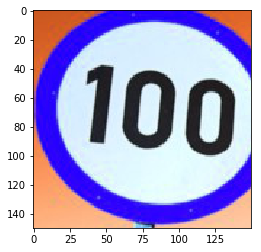

In [34]:
image_copy=image
image = cv2.resize(image, (32, 32))
# img = np.array(img).reshape(1, 32, 32, 1)

image = np.sum(image/3, axis=2, keepdims=True)
image = (image-128)/128
print(image.shape)


plt.imshow(image_copy)
plt.show()

In [35]:
img=[]
img.append(image)

(32, 32, 1)


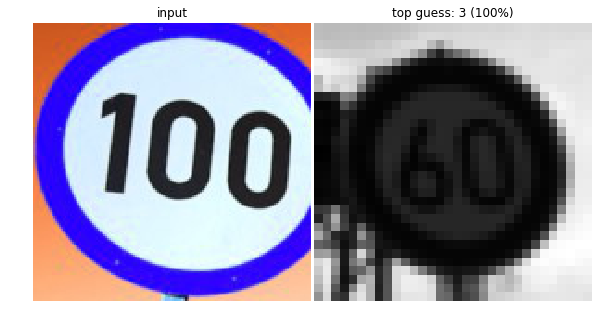

In [36]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=1)

# image = set_of_images[25*60 + 9]
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: img, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: img, keep_prob: 1.0})
    
    fig, axs = plt.subplots(1 ,2, figsize=(10, 6))
    fig.subplots_adjust(hspace = .4, wspace=.01)
    axs = axs.ravel()

    axs[0].axis('off')
    print(img[0].shape)
    axs[0].imshow(image_copy)
    axs[0].set_title('input')
    
    guess = my_top_k[1][0][0]
    index = np.argwhere(y_valid == guess)[0]
    axs[1].axis('off')
    axs[1].imshow(x_valid[index].squeeze(), cmap='gray')
    axs[1].set_title('top guess: {} ({:.0f}%)'.format(guess, 100*my_top_k[0][0][0]))
        
    plt.show()

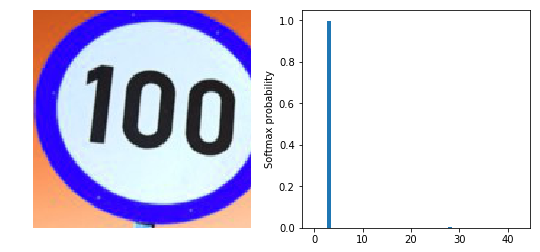

In [37]:
fig, axs = plt.subplots(1,2, figsize=(9, 4))
axs = axs.ravel()

n_classes = 43

for i in range(len(my_softmax_logits)*2):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(image_copy)
    else:
        axs[i].bar(np.arange(n_classes), my_softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Softmax probability')
        
plt.show()